In [1]:
from pathlib import Path

repo_dir = Path("./ml-mobileclip")
                
if not repo_dir.exists():
    !git clone https://github.com/apple/ml-mobileclip.git

In [2]:
%pip install -q "./ml-mobileclip" --extra-index-url "https://download.pytorch.org/whl/cpu"
%pip install -q "openvino>=2024.0.0" "nncf>=2.9.0" "gradio" "matplotlib" "Pillow"  "altair" "pandas" "opencv-python"


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
/bin/bash: -c: line 0: unexpected EOF while looking for matching `"'
/bin/bash: -c: line 1: syntax error: unexpected end of file
Note: you may need to restart the kernel to use updated packages.


In [3]:
import ipywidgets as widgets

model_dir = Path("checkpoints")

supported_models = {
    "MobileCLIP": {
        "mobileclip_s0": {"model_name": "mobileclip_s0", "pretrained": model_dir / "mobileclip_s0.pt", "url": "https://docs-assets.developer.apple.com/ml-research/datasets/mobileclip/mobileclip_s0.pt", "image_size": 256},
        "mobileclip_s1": {"model_name": "mobileclip_s1", "pretrained": model_dir / "mobileclip_s1.pt", "url": "https://docs-assets.developer.apple.com/ml-research/datasets/mobileclip/mobileclip_s1.pt", "image_size": 256},
        "mobileclip_s2": {"model_name": "mobileclip_s0", "pretrained": model_dir / "mobileclip_s2.pt", "url": "https://docs-assets.developer.apple.com/ml-research/datasets/mobileclip/mobileclip_s2.pt", "image_size": 256},
        "mobileclip_b": {"model_name": "mobileclip_b", "pretrained": model_dir / "mobileclip_b.pt", "url": "https://docs-assets.developer.apple.com/ml-research/datasets/mobileclip/mobileclip_b.pt", "image_size": 224},
        "mobileclip_blt": {"model_name": "mobileclip_b", "pretrained": model_dir / "mobileclip_blt.pt", "url": "https://docs-assets.developer.apple.com/ml-research/datasets/mobileclip/mobileclip_blt.pt", "image_size": 224},
    },
    "CLIP": {
        "clip-vit-b-32": {"model_name": "ViT-B-32", "pretrained": "laion2b_s34b_b79k", "image_size": 224},
        "clip-vit-b-16": {"image_name": "ViT-B-16", "pretrained": "openai", "image_size": 224},
        "clip-vit-l-14": {"image_name": "ViT-L-14", "pretrained": "datacomp_xl_s13b_b90k", "image_size": 224},
        "clip-vit-h-14": {"image_name": "ViT-H-14", "pretrained": "laion2b_s32b_b79k", "image_size": 224},
    },
    "SigLIP": {
        "siglip-vit-b-16": {"model_name": "ViT-B-16-SigLIP", "pretrained": "webli", "image_size": 224},
        "siglip-vit-l-16": {"model_name": "ViT-L-16-SigLIP-256", "pretrained": "webli", "image_size": 256},
    }
    
}


model_type = widgets.Dropdown(options=supported_models.keys(), default="MobileCLIP", description="Select model type:")
model_type

Dropdown(description='Select model type:', options=('MobileCLIP', 'CLIP', 'SigLIP'), value='MobileCLIP')

In [4]:
available_models = supported_models[model_type.value]

model_checkpoint = widgets.Dropdown(options=available_models.keys(), default=list(available_models), description="Select model:")

model_checkpoint

Dropdown(description='Select model:', options=('mobileclip_s0', 'mobileclip_s1', 'mobileclip_s2', 'mobileclip_…

In [5]:
import urllib.request
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py',
    filename='notebook_utils.py'
)

from notebook_utils import download_file

model_config = available_models[model_checkpoint.value]

In [6]:
from typing import List
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


def visualize_result(image:Image, labels:List[str], probs:np.ndarray, top:int = 5):
    """
    Utility function for visualization classification results
    params:
      image: input image
      labels: list of classification labels
      probs: model predicted softmaxed probabilities for each label
      top: number of the highest probability results for visualization
    returns:
      None
    """
    plt.figure(figsize=(64, 64))
    top_labels = np.argsort(-probs)[:min(top, probs.shape[0])]
    top_probs = probs[top_labels]
    plt.subplot(8, 8, 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(8, 8, 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs)
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [labels[index] for index in top_labels])
    plt.xlabel("probability")

sample_path = Path("data/coco.jpg")
sample_path.parent.mkdir(parents=True, exist_ok=True)
urllib.request.urlretrieve(
    "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco.jpg",
    sample_path,
)
image = Image.open(sample_path)

input_labels = ['cat', 'dog', 'wolf', 'tiger', 'man', 'horse', 'frog', 'tree', 'house', 'computer']
text_descriptions = [f"This is a photo of a {label}" for label in input_labels]

In [7]:
import torch
import time
from PIL import Image
import mobileclip
import open_clip

model_name = model_config["model_name"]
pretrained = model_config["pretrained"]
if model_type.value == "MobileCLIP":
    model_dir.mkdir(exist_ok=True)
    model_url = model_config["url"]
    download_file(model_url, directory=model_dir)
    model, _, preprocess = mobileclip.create_model_and_transforms(model_name, pretrained=pretrained)
    tokenizer = mobileclip.get_tokenizer(model_name)
else:
    model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained=pretrained)
    tokenizer = open_clip.get_tokenizer(model_name)

'checkpoints/mobileclip_s0.pt' already exists.


Image encoding took 0.0793 ms
Text encoding took 0.0453 ms


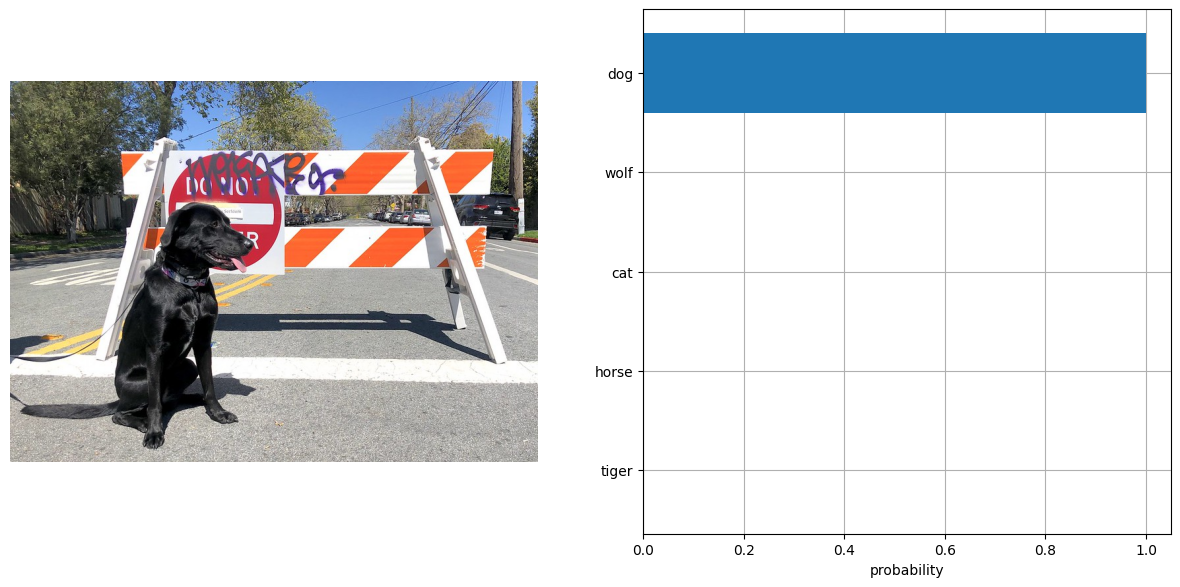

In [8]:
image = Image.open(sample_path).convert('RGB')
image_tensor = preprocess(image).unsqueeze(0)
text = tokenizer(text_descriptions)


with torch.no_grad():

    image_encoding_start = time.perf_counter()
    image_features = model.encode_image(image_tensor)
    image_encoding_end = time.perf_counter()
    print(f"Image encoding took {image_encoding_end - image_encoding_start:.3} ms")
    text_encoding_start = time.perf_counter()
    text_features = model.encode_text(text)
    text_encoding_end = time.perf_counter()
    print(f"Text encoding took {text_encoding_end - text_encoding_start:.3} ms")
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

visualize_result(image, input_labels, text_probs.detach().numpy()[0])

In [9]:
import types
import torch.nn.functional as F


def se_block_forward(self, inputs):
    """Apply forward pass."""
    b, c, h, w = inputs.size()
    x = F.avg_pool2d(inputs, kernel_size=[8, 8])
    x = self.reduce(x)
    x = F.relu(x)
    x = self.expand(x)
    x = torch.sigmoid(x)
    x = x.view(-1, c, 1, 1)
    return inputs * x

In [10]:
import openvino as ov
import gc

ov_models_dir = Path("ov_models")
ov_models_dir.mkdir(exist_ok=True)

image_encoder_path = ov_models_dir / f"{model_checkpoint.value}_im_encoder.xml"

if not image_encoder_path.exists():
    if "mobileclip_s" in model_name:
        model.image_encoder.model.conv_exp.se.forward = types.MethodType(se_block_forward, model.image_encoder.model.conv_exp.se)
    model.forward = model.encode_image
    ov_image_encoder = ov.convert_model(model, example_input=image_tensor, input=[-1, 3, image_tensor.shape[2], image_tensor.shape[3]])
    ov.save_model(ov_image_encoder, image_encoder_path)
    del ov_image_encoder
    gc.collect()

text_encoder_path = ov_models_dir / f"{model_checkpoint.value}_text_encoder.xml"

if not text_encoder_path.exists():
    model.forward = model.encode_text
    ov_text_encoder = ov.convert_model(model, example_input=text, input=[-1, text.shape[1]])
    ov.save_model(ov_text_encoder, text_encoder_path)
    del ov_text_encoder
    gc.collect()

del model
gc.collect();

In [11]:
core = ov.Core()

import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='AUTO')

In [12]:
ov_compiled_image_encoder = core.compile_model(image_encoder_path, device.value)
ov_compiled_image_encoder(image_tensor);

In [13]:
device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='AUTO')

In [14]:
ov_compiled_text_encoder = core.compile_model(text_encoder_path, device.value)
ov_compiled_text_encoder(text);

Image encoding took 0.00882 ms
Text encoding took 0.0238 ms


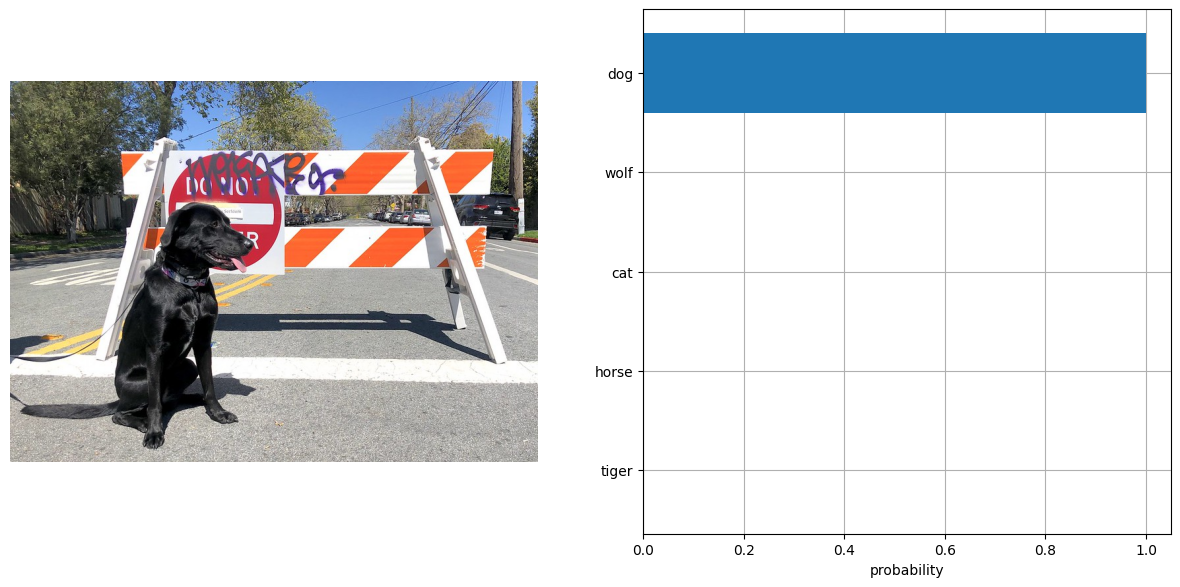

In [15]:
image_encoding_start = time.perf_counter()
image_features = torch.from_numpy(ov_compiled_image_encoder(image_tensor)[0])
image_encoding_end = time.perf_counter()
print(f"Image encoding took {image_encoding_end - image_encoding_start:.3} ms")
text_encoding_start = time.perf_counter()
text_features = torch.from_numpy(ov_compiled_text_encoder(text)[0])
text_encoding_end = time.perf_counter()
print(f"Text encoding took {text_encoding_end - text_encoding_start:.3} ms")
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

visualize_result(image, input_labels, text_probs.detach().numpy()[0])

In [ ]:
import altair as alt
import cv2
import gradio as gr
import numpy as np
import pandas as pd
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.functional import to_pil_image, to_tensor
from torchvision.transforms import (
    CenterCrop,
    Compose,
    InterpolationMode,
    Resize,
    ToTensor,
)
from open_clip.transform import image_transform


current_device = device.value
current_model = image_encoder_path.name.split("_im_encoder")[0]

available_converted_models = [model_file.name.split("_im_encoder")[0] for model_file in ov_models_dir.glob("*_im_encoder.xml")]
available_devices = list(core.available_devices) + ["AUTO"]

def get_preprocess_and_tokenizer(model_name):
    if "mobileclip" in model_name:
        resolution = supported_models["MobileCLIP"][model_name]["image_size"]
        resize_size = resolution
        centercrop_size = resolution
        aug_list = [
            Resize(
                resize_size,
                interpolation=InterpolationMode.BILINEAR,
            ),
            CenterCrop(centercrop_size),
            ToTensor(),
        ]
        preprocess = Compose(aug_list)
        tokenizer = mobileclip.get_tokenizer(supported_models["MobileCLIP"][model_name]["model_name"])
    else:
        model_configs = supported_models["SigLIP"] if "siglip" in model_name else supported_models["CLIP"]
        resize_size = model_configs[model_name]["image_size"]
        preprocess = image_transform((resize_size, resize_size), is_train=False, resize_mode="longest")
        tokenizer = open_clip.get_tokenizer(model_configs[model_name]["model_name"])

    return preprocess, tokenizer
        

def run(
    path: str,
    text_search: str,
    image_search: Image.Image,
    model_name: str,
    device: str,
    thresh: float,
    stride: int,
    batch_size: int,
):

    assert path, "An input video should be provided"
    assert (
        text_search is not None or image_search is not None
    ), "A text or image query should be provided"
    global current_model
    global current_device
    global preprocess
    global tokenizer
    global ov_compiled_image_encoder
    global ov_compiled_text_encoder


    if current_model != model_name or device != current_device:
        ov_compiled_image_encoder = core.compile_model(ov_models_dir / f"{model_name}_im_encoder.xml", device)
        ov_compiled_text_encoder = core.compile_model(ov_models_dir / f"{model_name}_text_encoder.xml", device)
        preprocess, tokenizer = get_preprocess_and_tokenizer(model_name)
        current_model = model_name
        current_device = device
    # Load video
    dataset = LoadVideo(path, transforms=preprocess, vid_stride=stride)
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=False, num_workers=0
    )
        

    # Get text query features
    if text_search:
        # Tokenize search phrase
        text = tokenizer([text_search])

        # Encode text query
        query_features = torch.from_numpy(ov_compiled_text_encoder(text)[0])
        query_features /= query_features.norm(dim=-1, keepdim=True)

    # Get image query features
    else:
        image = preprocess(image_search).unsqueeze(0)
        query_features = torch.from_numpy(ov_compiled_image_encoder(image)[0])
        query_features /= query_features.norm(dim=-1, keepdim=True)

    # Encode each frame and compare with query features
    matches = []
    res = pd.DataFrame(columns=["Frame", "Timestamp", "Similarity"])
    for image, orig, frame, timestamp in dataloader:
        with torch.no_grad():
            image_features = torch.from_numpy(ov_compiled_image_encoder(image)[0])

        image_features /= image_features.norm(dim=-1, keepdim=True)
        probs = query_features.cpu().numpy() @ image_features.cpu().numpy().T
        probs = probs[0]

        # Save frame similarity values
        df = pd.DataFrame(
            {
                "Frame": frame.tolist(),
                "Timestamp": torch.round(timestamp / 1000, decimals=2).tolist(),
                "Similarity": probs.tolist(),
            }
        )
        res = pd.concat([res, df])

        # Check if frame is over threshold
        for i, p in enumerate(probs):
            if p > thresh:
                matches.append(to_pil_image(orig[i]))

        print(f"Frames: {frame.tolist()} - Probs: {probs}")

    # Create plot of similarity values
    lines = (
        alt.Chart(res)
        .mark_line(color="firebrick")
        .encode(
            alt.X("Timestamp", title="Timestamp (seconds)"),
            alt.Y("Similarity", scale=alt.Scale(zero=False)),
        )
    ).properties(width=600)
    rule = alt.Chart().mark_rule(strokeDash=[6, 3], size=2).encode(y=alt.datum(thresh))

    return lines + rule, matches[:20]  # Only return up to 30 images to not crash the UI


class LoadVideo(Dataset):
    def __init__(self, path, transforms, vid_stride=1):

        self.transforms = transforms
        self.vid_stride = vid_stride
        self.cur_frame = 0
        self.cap = cv2.VideoCapture(path)
        self.total_frames = int(
            self.cap.get(cv2.CAP_PROP_FRAME_COUNT) / self.vid_stride
        )

    def __getitem__(self, _):
        # Read video
        # Skip over frames
        for _ in range(self.vid_stride):
            self.cap.grab()
            self.cur_frame += 1

        # Read frame
        _, img = self.cap.retrieve()
        timestamp = self.cap.get(cv2.CAP_PROP_POS_MSEC)

        # Convert to PIL
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(np.uint8(img))

        # Apply transforms
        img_t = self.transforms(img)

        return img_t, to_tensor(img), self.cur_frame, timestamp

    def __len__(self):
        return self.total_frames
            
                
        
desc_text = """
Search the content's of a video with a text description.
__Note__: Long videos (over a few minutes) may cause UI performance issues.
    """
text_app = gr.Interface(
    description=desc_text,
    fn=run,
    inputs=[
        gr.Video(label="Video"),
        gr.Textbox(label="Text Search Query"),
        gr.Image(label="Image Search Query", visible=False),
        gr.Dropdown(label="Model", choices=available_converted_models, value=model_checkpoint.value),
        gr.Dropdown(label="Device", choices=available_devices, value=device.value),
        gr.Slider(label="Threshold", maximum=1.0, value=0.2),
        gr.Slider(label="Frame-rate Stride", value=4, step=1),
        gr.Slider(label="Batch Size", value=4, step=1),
    ],
    outputs=[
        gr.Plot(label="Similarity Plot"),
        gr.Gallery(label="Matched Frames", columns=2, object_fit="contain", height="auto")
    ],
    allow_flagging="never",
)

desc_image = """
Search the content's of a video with an image query.
__Note__: Long videos (over a few minutes) may cause UI performance issues.
    """
image_app = gr.Interface(
    description=desc_image,
    fn=run,
    inputs=[
        gr.Video(label="Video"),
        gr.Textbox(label="Text Search Query", visible=False),
        gr.Image(label="Image Search Query", type="pil"),
        gr.Dropdown(label="Model", choices=available_converted_models, value=model_checkpoint.value),
        gr.Dropdown(label="Device", choices=available_devices, value=device.value),
        gr.Slider(label="Threshold", maximum=1.0, value=0.2),
        gr.Slider(label="Frame-rate Stride", value=4, step=1),
        gr.Slider(label="Batch Size", value=4, step=1),
    ],
    outputs=[
        gr.Plot(label="Similarity Plot"),
        gr.Gallery(label="Matched Frames", columns=2, object_fit="contain", height="auto")
    ],
    allow_flagging="never",
    )
app = gr.TabbedInterface(
    interface_list=[text_app, image_app],
    tab_names=["Text Query Search", "Image Query Search"],
    title="CLIP Video Content Search",
)
    
    
app.launch()